# Bubble Analysis in NGC628

This notebook implements the tasks described in the TASKS.md file for analyzing bubble properties in the NGC628 galaxy.

## Milestone 0: Basics
- Using Jupyter Notebook
- Adhering to PEP-8
- Detailed documentation in README.md and this notebook
- Maintaining a copilot_log.txt file

In [1]:
# Import necessary libraries
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

## Milestone 1: Modifying and Updating Bubbles Data File

1. Read the jwst_bubble_properties_A.csv file using astropy tables
2. Create new columns RA_DEG and DEC_DEG
3. Convert RA_DMS and DEC_DMS to degree from sexagesimal (dms) using SkyCoord
4. Add SEMI_MAJ_ARCSEC and SEMI_MIN_ARCSEC columns (scaled from parsecs to arcseconds)

In [2]:
# Read the data file
bubble_data = Table.read('jwst_bubble_properties_A.csv', format='csv')

# Display the first few rows
bubble_data[:5]

ID,RA_DMS,DEC_DMS,SEMI_MAJ_PC,SEMI_MIN_PC,AVG_RAD_PC,PA_DEG,ARM,DIST_ARM_PC,GAL_RAD_KPC
int64,str11,str11,int64,int64,int64,int64,int64,int64,float64
1,24d08m55.9s,15d48m7.9s,86,86,86,0,3,145,5.22
2,24d08m56.7s,15d48m2.9s,24,24,24,0,3,127,5.05
3,24d08m57.0s,15d48m9.0s,42,42,42,0,3,138,5.21
4,24d08m58.0s,15d47m44.9s,25,25,25,0,3,101,4.54
5,24d08m58.2s,15d48m2.6s,24,24,24,0,3,114,4.98


In [3]:
# Convert RA_DMS and DEC_DMS to degrees
# NOTE: According to README.txt, both RA_DMS and DEC_DMS are in degrees, minutes, seconds format
coords = SkyCoord(bubble_data['RA_DMS'], bubble_data['DEC_DMS'], unit=(u.deg, u.deg))

# Create new columns
bubble_data['RA_DEG'] = coords.ra.degree
bubble_data['DEC_DEG'] = coords.dec.degree

# Display the updated table
bubble_data[:5]

ID,RA_DMS,DEC_DMS,SEMI_MAJ_PC,SEMI_MIN_PC,AVG_RAD_PC,PA_DEG,ARM,DIST_ARM_PC,GAL_RAD_KPC,RA_DEG,DEC_DEG
int64,str11,str11,int64,int64,int64,int64,int64,int64,float64,float64,float64
1,24d08m55.9s,15d48m7.9s,86,86,86,0,3,145,5.22,24.14886111111111,15.802194444444446
2,24d08m56.7s,15d48m2.9s,24,24,24,0,3,127,5.05,24.149083333333333,15.800805555555556
3,24d08m57.0s,15d48m9.0s,42,42,42,0,3,138,5.21,24.149166666666666,15.8025
4,24d08m58.0s,15d47m44.9s,25,25,25,0,3,101,4.54,24.149444444444445,15.795805555555555
5,24d08m58.2s,15d48m2.6s,24,24,24,0,3,114,4.98,24.1495,15.800722222222223


In [4]:
# Calculate angular sizes (in arcseconds)
# Distance to galaxy = 9.84 Mpc
distance = 9.84 * u.Mpc

# Function to convert parsecs to arcseconds at the given distance
def pc_to_arcsec(pc_value, distance=distance):
    """Convert parsecs to arcseconds at a given distance"""
    # Create a spatial length
    length = pc_value * u.pc
    # Convert to angular size using small-angle approximation
    # We need to use the equivalency because length/distance is dimensionless
    # but we want to express it as an angle
    return (length / distance * u.radian).to(u.arcsec).value

# Add new columns for angular sizes
bubble_data['SEMI_MAJ_ARCSEC'] = [pc_to_arcsec(val) for val in bubble_data['SEMI_MAJ_PC']]
bubble_data['SEMI_MIN_ARCSEC'] = [pc_to_arcsec(val) for val in bubble_data['SEMI_MIN_PC']]

# Display the updated table
bubble_data[:5]

ID,RA_DMS,DEC_DMS,SEMI_MAJ_PC,SEMI_MIN_PC,AVG_RAD_PC,PA_DEG,ARM,DIST_ARM_PC,GAL_RAD_KPC,RA_DEG,DEC_DEG,SEMI_MAJ_ARCSEC,SEMI_MIN_ARCSEC
int64,str11,str11,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
1,24d08m55.9s,15d48m7.9s,86,86,86,0,3,145,5.22,24.14886111111111,15.802194444444446,1.8027208676067363,1.8027208676067363
2,24d08m56.7s,15d48m2.9s,24,24,24,0,3,127,5.05,24.149083333333333,15.800805555555556,0.5030848932856008,0.5030848932856008
3,24d08m57.0s,15d48m9.0s,42,42,42,0,3,138,5.21,24.149166666666666,15.8025,0.8803985632498015,0.8803985632498015
4,24d08m58.0s,15d47m44.9s,25,25,25,0,3,101,4.54,24.149444444444445,15.795805555555555,0.5240467638391675,0.5240467638391675
5,24d08m58.2s,15d48m2.6s,24,24,24,0,3,114,4.98,24.1495,15.800722222222223,0.5030848932856008,0.5030848932856008


In [5]:
# Save the updated table
bubble_data.write('jwst_bubble_properties_A_updated.csv', format='csv', overwrite=True)
print("Updated table saved as 'jwst_bubble_properties_A_updated.csv'")

Updated table saved as 'jwst_bubble_properties_A_updated.csv'


## Additional Information

- Pixel scale: 0.11 arcsec/pix
- Galaxy distance: 9.84 Mpc

The SEMI_MAJ_ARCSEC and SEMI_MIN_ARCSEC columns can be used to overlay the bubbles on JWST images in future milestones.

## Milestone 2: Displaying the Bubbles as Overlays over JWST FITS File

1. Load the JWST FITS file using astropy.io.fits
2. Convert RA/DEC to pixel coordinates using astropy.wcs.WCS
3. Plot the image using matplotlib and overlay the bubbles as ellipses

In [6]:
# Import additional libraries needed for Milestone 2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import os

# Set up a larger figure size for better visualization
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 12

In [17]:
# Load the JWST FITS file
fits_file = 'hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits'

# Check if the file exists
if os.path.exists(fits_file):
    # Open the FITS file
    hdul = fits.open(fits_file)
    
    # Print basic info about the FITS file
    print(f"FITS file information:")
    hdul.info()
    
    # Get the image data and header
    image_data = hdul[1].data  # JWST science data is typically in extension 1
    header = hdul[1].header
    
    # Create a WCS object from the header
    wcs = WCS(header)
    print(f"WCS info: {wcs}")
    
    # Close the FITS file
    hdul.close()
    
    # Quick look at some statistics of the image
    print(f"Image shape: {image_data.shape}")
    print(f"Min pixel value: {np.nanmin(image_data)}")
    print(f"Max pixel value: {np.nanmax(image_data)}")
    print(f"Mean pixel value: {np.nanmean(image_data)}")
else:
    print(f"Error: FITS file '{fits_file}' not found. Please check the file path.")

FITS file information:
Filename: hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  SCI           1 ImageHDU        75   (1891, 2600)   float32   
  2  ERR           1 ImageHDU        10   (1891, 2600)   float32   
  3  CON           1 ImageHDU        10   (1891, 2600, 1)   int32   
  4  WHT           1 ImageHDU         9   (1891, 2600)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1891, 2600)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1891, 2600)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1891, 2600)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [129934B]   
WCS info: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 24.171642007329 15.788103283 
CRPIX : 942.62798074861 1302.079567189 
PC1_1 PC1_2  : -0.99999998836263 0.00015305834175289 
PC2_1 PC2_2  : 0.00015305835402243 0.9999999881

Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


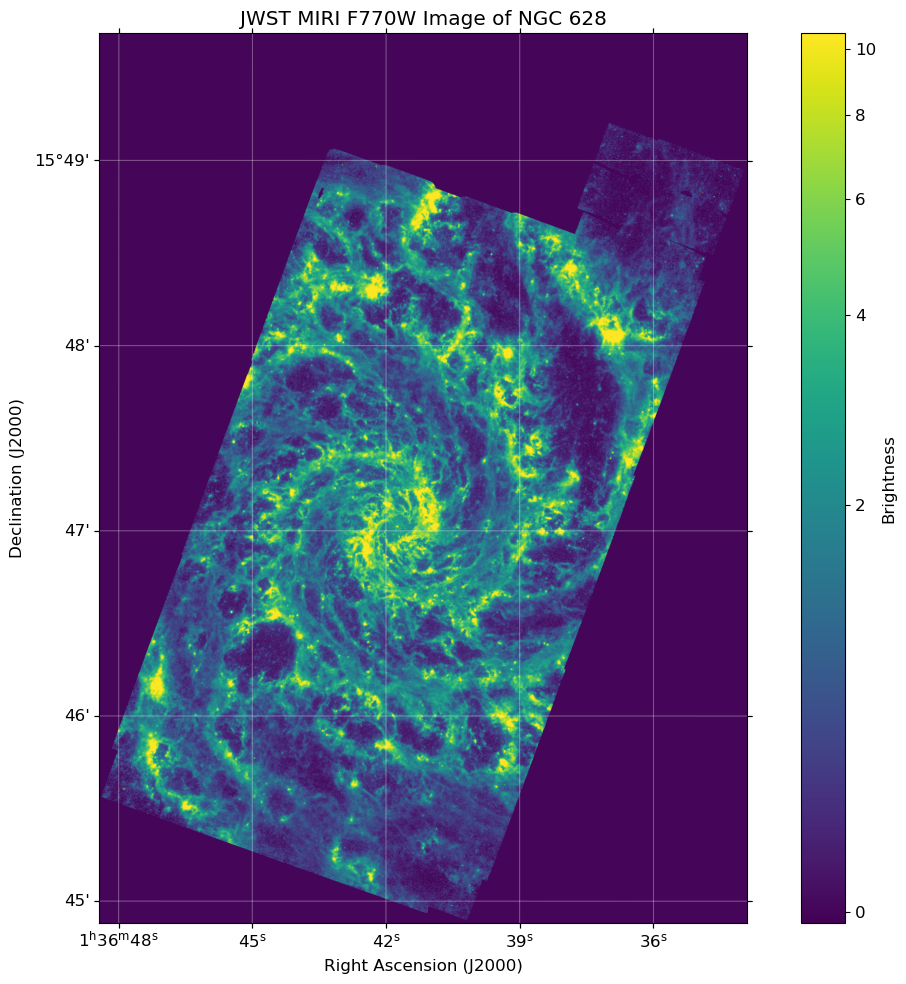

In [18]:
# Create a figure and display the image
fig = plt.figure(figsize=(12, 10))

# Add a subplot with WCS projection
ax = plt.subplot(projection=wcs)

# Normalize the image data for better visualization
norm = simple_norm(image_data, 'asinh', percent=99)

# Display the image with custom normalization
im = ax.imshow(image_data, origin='lower', cmap='viridis', norm=norm)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, label='Brightness')

# Set axis labels and title
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
ax.set_title('JWST MIRI F770W Image of NGC 628')

# Add grid lines for RA and Dec
ax.grid(color='white', ls='solid', alpha=0.3)

plt.tight_layout()
plt.show()

Adding 1694 bubble overlays...


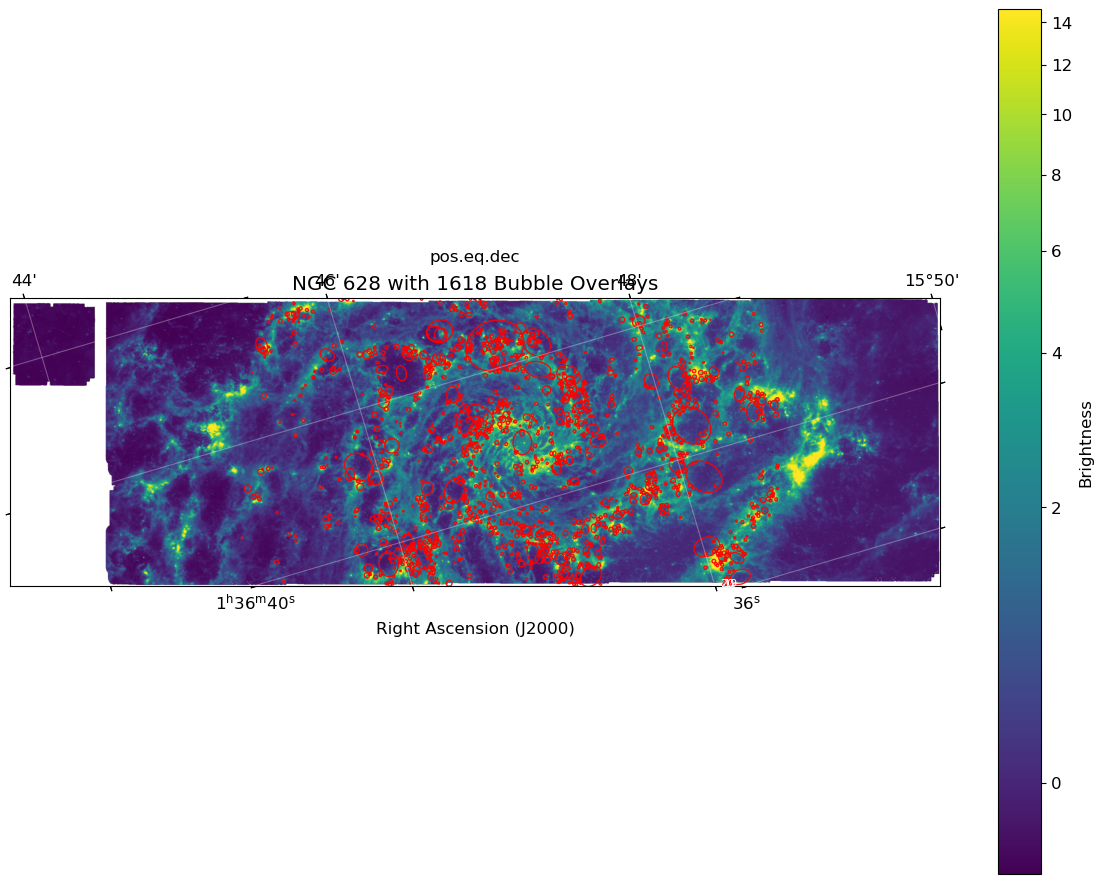

Successfully plotted 1618 out of 1694 bubbles


In [ ]:
# Load the updated bubble data
bubble_data_updated = Table.read('jwst_bubble_properties_A_updated.csv', format='csv')

# Create a figure for the image with bubble overlays
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(projection=wcs)

# Display the image
im = ax.imshow(image_data, origin='lower', cmap='viridis', norm=norm)
cbar = plt.colorbar(im, ax=ax, label='Brightness')

# Calculate number of bubbles to overlay
num_bubbles = len(bubble_data_updated)
print(f"Adding {num_bubbles} bubble overlays...")

# Create a SkyCoord object for all bubbles at once for better efficiency
all_coords = SkyCoord(bubble_data_updated['RA_DEG'], bubble_data_updated['DEC_DEG'], unit='deg')

# Convert all coordinates to pixel coordinates at once
pix_x, pix_y = wcs.world_to_pixel(all_coords)

# Count how many bubbles are successfully plotted
plotted_count = 0

# Overlay the bubbles as ellipses
for i, bubble in enumerate(bubble_data_updated):
    # Get the pixel coordinates
    x, y = pix_x[i], pix_y[i]
    
    # Check if coordinates are within the image boundaries
    if (0 <= x < image_data.shape[1]) and (0 <= y < image_data.shape[0]):
        try:
            # Get the bubble properties
            semi_maj = bubble['SEMI_MAJ_ARCSEC'] / 0.111  # Convert to pixels (0.111 arcsec/pixel)
            semi_min = bubble['SEMI_MIN_ARCSEC'] / 0.111  # Convert to pixels
            
            # Position angle from the catalog needs to be adjusted for matplotlib
            # PA_DEG is given as position angle in degrees relative to x-axis (North up, East left)
            # In astronomy, PA is measured from North (up) toward East (left), i.e., counterclockwise
            # Matplotlib measures angles from the x-axis toward the counterclockwise direction
            # We need to adjust for the orientation of the WCS in the image
            
            # Get the position angle
            pa_deg = bubble['PA_DEG']
            
            # Create an ellipse patch
            # Note: matplotlib expects width and height (diameters) not radii
            e = Ellipse((x, y), 2*semi_maj, 2*semi_min, angle=90-pa_deg,  # Adjust angle for matplotlib
                       edgecolor='red', facecolor='none', linewidth=1.0, alpha=0.9)
            
            # Add the ellipse to the plot
            ax.add_patch(e)
            
            # Add a small text label with the bubble ID for the first few bubbles only
            if i < 20:  # Limit the number of labels to avoid cluttering
                ax.text(x, y, str(bubble['ID']), color='white', fontsize=8, ha='center', va='center')
                
            plotted_count += 1
                
        except Exception as e:
            print(f"Error plotting bubble {bubble['ID']}: {e}")

# Set axis labels and title
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
ax.set_title(f'NGC 628 with {plotted_count} Bubble Overlays')

# Add grid lines
ax.grid(color='white', ls='solid', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Successfully plotted {plotted_count} out of {num_bubbles} bubbles")

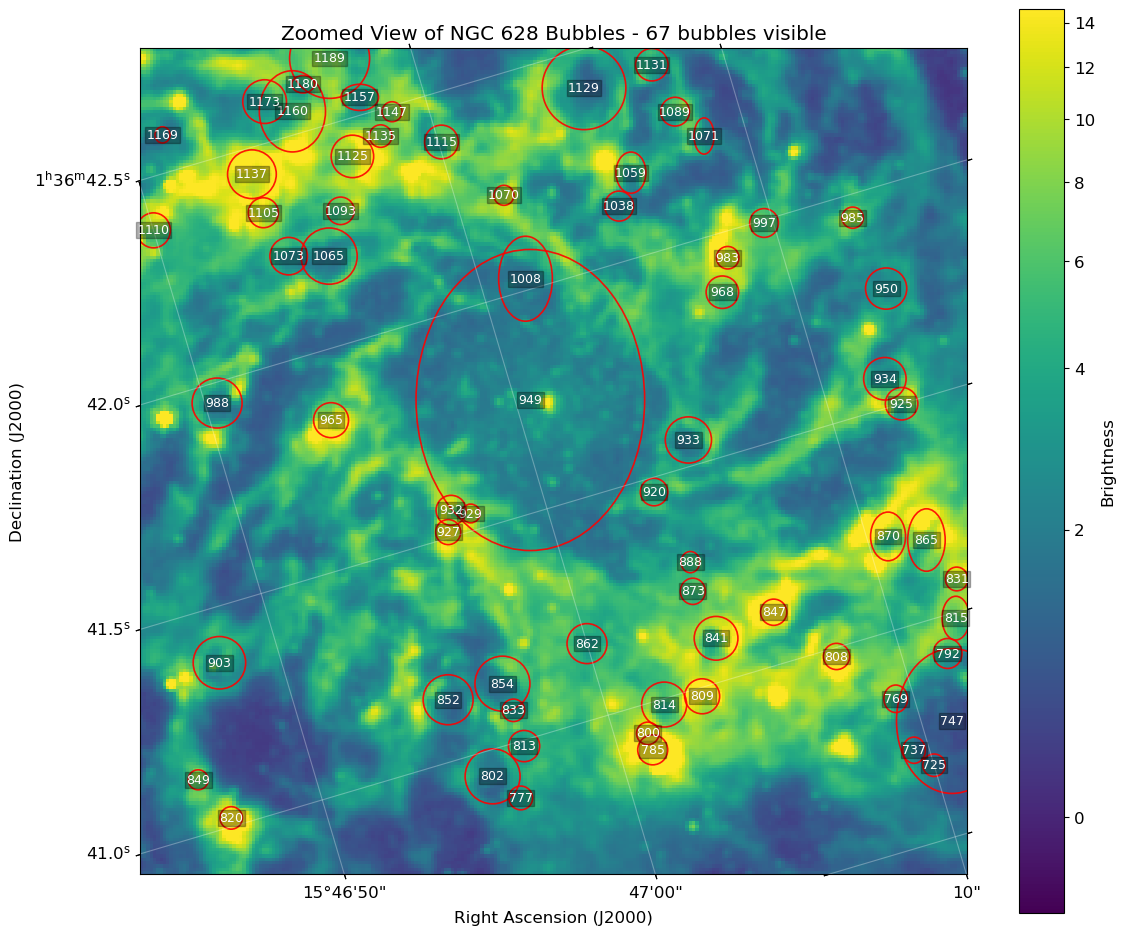

Displayed 67 bubbles in the zoomed view


In [ ]:
# Create a zoomed-in view of a portion of the image with bubbles
# This helps to better visualize the bubbles in a crowded field

# Let's find a region with a few bubbles to zoom in
# We'll use the first few bubbles as reference
if len(bubble_data_updated) > 0:
    # Calculate the median RA and DEC to center the view
    # This ensures we zoom into an area where bubbles are actually present
    in_image_mask = (pix_x >= 0) & (pix_x < image_data.shape[1]) & (pix_y >= 0) & (pix_y < image_data.shape[0])
    
    if np.any(in_image_mask):
        # Get median position of bubbles in the image
        median_x = np.median(pix_x[in_image_mask])
        median_y = np.median(pix_y[in_image_mask])
        
        # Create a new figure with a zoomed view
        fig = plt.figure(figsize=(12, 10))
        ax = plt.subplot(projection=wcs)
        
        # Define the zoom region (250x250 pixels centered on the median position)
        zoom_size = 250  # pixels
        x_min, x_max = max(0, median_x - zoom_size//2), min(image_data.shape[1], median_x + zoom_size//2)
        y_min, y_max = max(0, median_y - zoom_size//2), min(image_data.shape[0], median_y + zoom_size//2)
        
        # Set the axis limits for the zoomed region
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        # Display the image
        im = ax.imshow(image_data, origin='lower', cmap='viridis', norm=norm)
        cbar = plt.colorbar(im, ax=ax, label='Brightness')
        
        # Count bubbles in zoom region
        zoom_count = 0
        
        # Overlay bubbles
        for i, bubble in enumerate(bubble_data_updated):
            x, y = pix_x[i], pix_y[i]
            
            # Check if this bubble is in our zoom region
            if x_min <= x <= x_max and y_min <= y <= y_max:
                try:
                    # Get the bubble properties
                    semi_maj = bubble['SEMI_MAJ_ARCSEC'] / 0.111  # Convert to pixels
                    semi_min = bubble['SEMI_MIN_ARCSEC'] / 0.111  # Convert to pixels
                    pa_deg = bubble['PA_DEG']
                    
                    # Create an ellipse patch
                    e = Ellipse((x, y), 2*semi_maj, 2*semi_min, angle=90-pa_deg,
                               edgecolor='red', facecolor='none', linewidth=1.2, alpha=0.9)
                    
                    # Add the ellipse to the plot
                    ax.add_patch(e)
                    
                    # Add a text label with the bubble ID
                    ax.text(x, y, str(bubble['ID']), color='white', fontsize=9, 
                            ha='center', va='center', bbox=dict(facecolor='black', alpha=0.3, pad=1))
                    
                    zoom_count += 1
                    
                except Exception as e:
                    print(f"Error plotting bubble {bubble['ID']} in zoomed view: {e}")
        
        # Set axis labels and title
        ax.set_xlabel('Right Ascension (J2000)')
        ax.set_ylabel('Declination (J2000)')
        ax.set_title(f'Zoomed View of NGC 628 Bubbles - {zoom_count} bubbles visible')
        
        # Add grid lines
        ax.grid(color='white', ls='solid', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Displayed {zoom_count} bubbles in the zoomed view")
    else:
        print("No bubbles found within the image boundaries for zooming")

In [20]:
## Milestone 3: Output a .reg file of the overlay

# Load the updated bubble data if not already loaded
from astropy.table import Table
if 'bubble_data_updated' not in locals():
    bubble_data_updated = Table.read('jwst_bubble_properties_A_updated.csv', format='csv')

# Create a .reg file for DS9 with the bubble overlays
def create_ds9_reg_file(data, output_file='ds9.reg'):
    """
    Create a DS9 region file from the bubble data.
    
    Parameters:
    -----------
    data : astropy.table.Table
        Table containing the bubble data with columns:
        RA_DEG, DEC_DEG, SEMI_MAJ_ARCSEC, SEMI_MIN_ARCSEC, PA_DEG
    output_file : str
        Name of the output region file
    """
    # Create the header for the DS9 region file
    header = [
        "# Region file format: DS9 version 4.1",
        "icrs"
    ]
    
    # Create a list to store the region definitions
    regions = []
    
    # Create a region definition for each bubble
    for bubble in data:
        ra_deg = bubble['RA_DEG']
        dec_deg = bubble['DEC_DEG']
        semi_maj_arcsec = bubble['SEMI_MAJ_ARCSEC']
        semi_min_arcsec = bubble['SEMI_MIN_ARCSEC']
        pa_deg = bubble['PA_DEG']
        
        # Format the region definition
        # The format is: ellipse(RA, DEC, SEMI_MAJ", SEMI_MIN", PA)
        region = f"ellipse({ra_deg:.6f}, {dec_deg:.6f}, {semi_maj_arcsec}\", {semi_min_arcsec}\", {pa_deg})"
        regions.append(region)
    
    # Write the regions to the file
    with open(output_file, 'w') as f:
        for line in header:
            f.write(line + '\n')
        for region in regions:
            f.write(region + '\n')
    
    print(f"Successfully wrote {len(regions)} regions to {output_file}")
    
# Create a DS9 region file for all bubbles
create_ds9_reg_file(bubble_data_updated, 'ngc628_all_bubbles.reg')

Successfully wrote 1694 regions to ngc628_all_bubbles.reg


In [21]:
# Create a region file for the top 15 largest bubbles
# Sort bubbles by semi-major axis (largest first)
sorted_bubbles = Table(bubble_data_updated, copy=True)
sorted_bubbles.sort('SEMI_MAJ_ARCSEC', reverse=True)

# Select top 15 largest bubbles
top_15_bubbles = sorted_bubbles[:15]

# Save them to a CSV file as well
top_15_bubbles.write('top_15_largest_bubbles.csv', format='csv', overwrite=True)

# Create a region file for just the top 15 bubbles
create_ds9_reg_file(top_15_bubbles, 'top_15_bubbles.reg')

# Display information about the top 15 bubbles
for i, bubble in enumerate(top_15_bubbles, 1):
    print(f"{i}. ID: {bubble['ID']}, Size: {bubble['SEMI_MAJ_ARCSEC']:.2f}\" × {bubble['SEMI_MIN_ARCSEC']:.2f}\", Position: ({bubble['RA_DEG']:.6f}, {bubble['DEC_DEG']:.6f})")

Successfully wrote 15 regions to top_15_bubbles.reg
1. ID: 1506, Size: 12.20" × 10.33", Position: (24.186000, 15.783611)
2. ID: 761, Size: 8.47" × 6.96", Position: (24.170167, 15.802667)
3. ID: 427, Size: 7.99" × 5.91", Position: (24.163889, 15.802361)
4. ID: 1450, Size: 6.44" × 5.03", Position: (24.184944, 15.788250)
5. ID: 1126, Size: 6.20" × 5.26", Position: (24.176722, 15.764639)
6. ID: 1222, Size: 6.16" × 3.82", Position: (24.178389, 15.779750)
7. ID: 98, Size: 5.45" × 3.92", Position: (24.155778, 15.800389)
8. ID: 1357, Size: 5.37" × 3.23", Position: (24.181806, 15.787583)
9. ID: 1611, Size: 5.35" × 4.65", Position: (24.189500, 15.778028)
10. ID: 811, Size: 5.24" × 3.90", Position: (24.170750, 15.774389)
11. ID: 460, Size: 5.20" × 3.19", Position: (24.164278, 15.768833)
12. ID: 482, Size: 5.14" × 3.98", Position: (24.164583, 15.764778)
13. ID: 1078, Size: 5.07" × 3.73", Position: (24.176056, 15.802722)
14. ID: 949, Size: 5.05" × 3.84", Position: (24.173972, 15.783472)
15. ID: 131

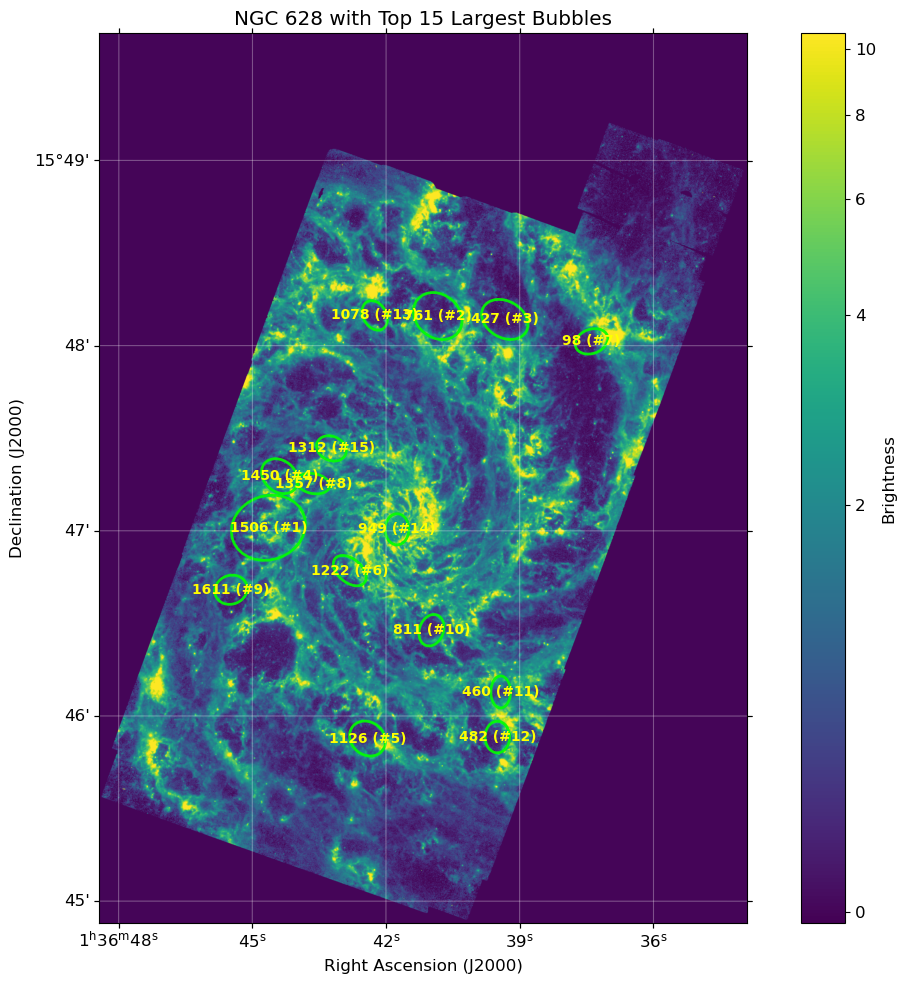

In [22]:
# Visualize the top 15 largest bubbles on the JWST image
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

# Create a figure for the image with the top 15 bubble overlays
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(projection=wcs)

# Display the image
im = ax.imshow(image_data, origin='lower', cmap='viridis', norm=norm)
cbar = plt.colorbar(im, ax=ax, label='Brightness')

# Create a SkyCoord object for the top 15 bubbles
top_coords = SkyCoord(top_15_bubbles['RA_DEG'], top_15_bubbles['DEC_DEG'], unit='deg')

# Convert coordinates to pixel coordinates
pix_x, pix_y = wcs.world_to_pixel(top_coords)

# Overlay the top 15 bubbles as ellipses
for i, bubble in enumerate(top_15_bubbles):
    # Get the pixel coordinates
    x, y = pix_x[i], pix_y[i]
    
    # Check if coordinates are within the image boundaries
    if (0 <= x < image_data.shape[1]) and (0 <= y < image_data.shape[0]):
        # Get the bubble properties
        semi_maj = bubble['SEMI_MAJ_ARCSEC'] / 0.111  # Convert to pixels (0.111 arcsec/pixel)
        semi_min = bubble['SEMI_MIN_ARCSEC'] / 0.111  # Convert to pixels
        pa_deg = bubble['PA_DEG']
        
        # Create an ellipse patch with a different color for better visibility
        e = Ellipse((x, y), 2*semi_maj, 2*semi_min, angle=90-pa_deg,
                   edgecolor='lime', facecolor='none', linewidth=2.0, alpha=0.9)
        
        # Add the ellipse to the plot
        ax.add_patch(e)
        
        # Add text label with the bubble ID and rank
        ax.text(x, y, f"{bubble['ID']} (#{i+1})", color='yellow', fontsize=10, 
                ha='center', va='center', weight='bold')

# Set axis labels and title
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
ax.set_title('NGC 628 with Top 15 Largest Bubbles')

# Add grid lines
ax.grid(color='white', ls='solid', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Verify the contents of the generated region files
import os

def check_region_file(file_path):
    """Check if a region file exists and display its first few lines"""
    if os.path.exists(file_path):
        print(f"File {file_path} exists. File size: {os.path.getsize(file_path)} bytes")
        print("\nFirst 10 lines:")
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for i, line in enumerate(lines[:10]):
                print(f"{i+1}: {line.strip()}")
        print(f"\nTotal lines: {len(lines)}")
    else:
        print(f"File {file_path} does not exist!")

# Check both region files
print("==== All Bubbles Region File ====")
check_region_file('ngc628_all_bubbles.reg')

print("\n==== Top 15 Bubbles Region File ====")
check_region_file('top_15_bubbles.reg')

==== All Bubbles Region File ====
File ngc628_all_bubbles.reg exists. File size: 127848 bytes

First 10 lines:
1: # Region file format: DS9 version 4.1
2: icrs
3: ellipse(24.148861, 15.802194, 1.8027208676067363", 1.8027208676067363", 0)
4: ellipse(24.149083, 15.800806, 0.5030848932856008", 0.5030848932856008", 0)
5: ellipse(24.149167, 15.802500, 0.8803985632498015", 0.8803985632498015", 0)
6: ellipse(24.149444, 15.795806, 0.5240467638391675", 0.5240467638391675", 0)
7: ellipse(24.149500, 15.800722, 0.5030848932856008", 0.5030848932856008", 0)
8: ellipse(24.149639, 15.794778, 0.6917417282677011", 0.6917417282677011", 0)
9: ellipse(24.149667, 15.797389, 0.6707798577141344", 0.6498179871605677", 0)
10: ellipse(24.149694, 15.794389, 0.8384748221426681", 0.8384748221426681", 0)

Total lines: 1696

==== Top 15 Bubbles Region File ====
File top_15_bubbles.reg exists. File size: 1165 bytes

First 10 lines:
1: # Region file format: DS9 version 4.1
2: icrs
3: ellipse(24.186000, 15.783611, 12.19

## Summary of Milestone 3

We have successfully implemented Milestone 3 by:

1. Creating a function `create_ds9_reg_file()` that generates DS9 region files from bubble data in the required format:
   ```
   # Region file format: DS9 version 4.1
   icrs
   ellipse(RA_DEG, DEC_DEG, SEMI_MAJ_ARCSEC", SEMI_MIN_ARCSEC", PA_DEG)
   ```

2. Generated two region files:
   - `ngc628_all_bubbles.reg`: Contains all 1694 bubbles from the dataset
   - `top_15_bubbles.reg`: Contains only the 15 largest bubbles for easier visualization

3. Created a visualization of the top 15 largest bubbles overlaid on the JWST image

4. Also saved the top 15 bubbles data to `top_15_largest_bubbles.csv` for reference

These region files can be loaded into DS9 or other astronomy visualization software to overlay the bubbles on any compatible image of NGC 628.